In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Basics of Derivative

In [86]:
# The slope of a function at a given point is equal to the value of its derivative at that point.

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
f(3.0)

20.0

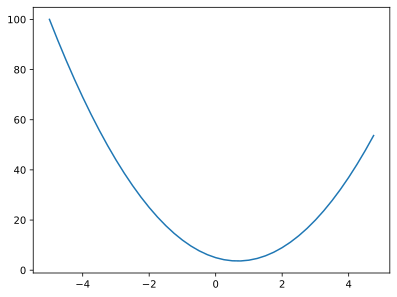

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [12]:
h = 0.0000001
x = 3.0
print(f'If we increase the x by h then the output of the function will increase by {f(x+h)-f(x)}')
print(f'Rise over run is slope {(f(x+h)-f(x))/h}')

If we increase the x by h then the output of the function will increase by 1.4000000305713911e-06
Rise over run is slope 14.000000305713911


In [13]:
# let's get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [14]:
# derivate of d wrt a

h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h # bumped a by small amount
d2 = a*b + c

print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h) # change in d wrt h

# d2-d1 will determine the sign of slope


d1  4.0
d2  3.999699999999999
slope  -3.000000000010772


In [15]:
# derivate of d wrt b

h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

b += h # bumped a by small amount
d2 = a*b + c

print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h)

d1  4.0
d2  4.0002
slope  2.0000000000042206


In [16]:
# derivate of d wrt c

h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

c += h # bumped a by small amount
d2 = a*b + c

print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h)

# the function will increase by the same amount as c is increased, so the slope is 1
# because the d2-d1 will be equal to h

d1  4.0
d2  4.0001
slope  0.9999999999976694


In [56]:
class Value:

    # _children will contain the Value objects on which operations are applied
    # _op will contain the operator which was applied on _children
    # _op will contain any label
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # grad maintains the derivative of L w.r.t this value (self) (dL/dLabel)
        # initially it's 0, means no effect, means during initialization no value impacts L
        # because grad=0 means changing this value doesn't change L
        self.grad = 0.0

    def __repr__(self) -> str: # this function helps with printing the values.
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [19]:
a = Value(2.0)
b = Value(-3.0)
a, b

(Value(data=2.0), Value(data=-3.0))

In [20]:
a + b # currently this won't work as python doesn't know how to add two Value objects
# it will give error TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [60]:
# after adding __add__, __mul__ functions and _children, _op, label & grad params to Value class
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a + b)
print(a * b)
# d = a*b+c # (a.__mul__(b)).__sum__(c)
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
print(d)

Value(data=-1.0)
Value(data=-6.0)
Value(data=4.0)


In [61]:
d._prev # contains e and c as children

{Value(data=-6.0), Value(data=10.0)}

In [62]:
d._op # contains the '+' operator between e and c

'+'

In [65]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

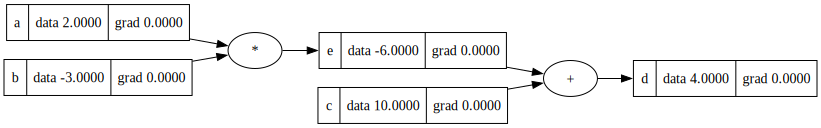

In [66]:
draw_dot(d)

In [73]:
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L


Value(data=-8.0)

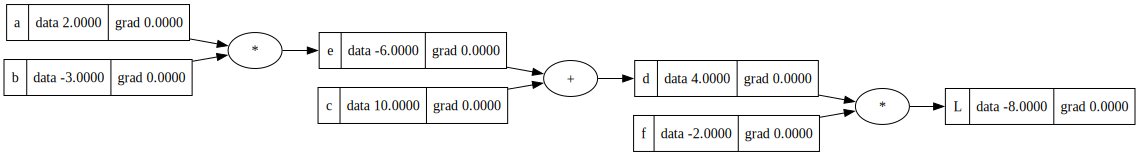

In [74]:
draw_dot(L)

### Backpropagation

In [54]:
# some of the vars (a, b,..., f) will be weights of the neural network and others represent the data.
# L is the loss function.
# we want to see how the change in weights impact the loss fn L.
# so, we'll compute the derivative of L with respect to each of these weight starting from the end i.e. L.

In [75]:
L.grad = 1.0 # dL/dL
# changing L by small amount h, changes L by h
# ((L+h) - L)/h = 1

In [81]:
# deriv of L wrt L
def rough1(): # just for proving stuff numerically

    h = 0.00001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data
    L2 = L.data + h

    print((L2 - L1)/h)

rough1()

0.9999999999621422


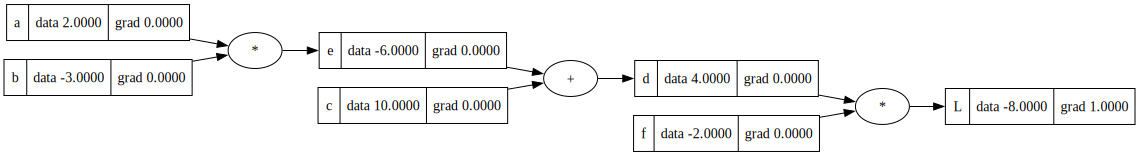

In [77]:
draw_dot(L)

In [85]:
# derivative of L wrt a
def rough2(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    # bumped a by h
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough2()

6.000000000021544


L = d*f

dL/df =? and dL/dd =?

dL/df =?

(f(x+h)-f(x))/h

(d*(f+h) - d*f)/h

= (d*f + d*h - d*f)/h

dL/df = d

similarly, dL/dd = f

so, the gradients of nodes having * between them is the value of the other variable

In [87]:
f.grad = 4.0 # value of d
d.grad = -2.0 # value of f

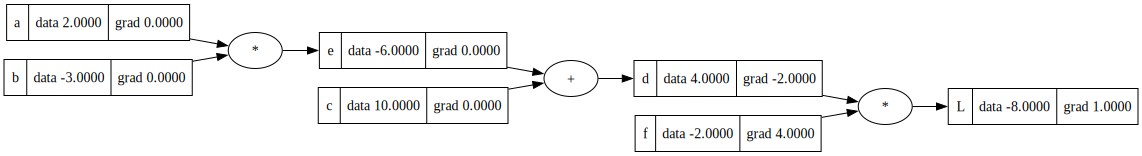

In [88]:
draw_dot(L)

In [89]:
# derivative of L wrt f
def rough3(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    # bumped f by h
    f = Value(-2.0 + h, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough3()

3.9999999999995595


we know how d and f impact L, now we want to know how c and e impact L.

dL/dc =? and dL/de =?

L = d*e; d = c+e

let's first see how c and e impact d

dd/de =? and dd/dc =?

dd/dc =>

(f(x+h)-f(x))/h

= ((c+h)+e - (c+e))/h

= h/h = 1.0

similarly dd/de = 1.

so, the impact of + node is 1.0 gradient

Now we know how e and c impact d, how do we calculate e and c's impact on L.

The answer is **Chain Rule**.

*If a variable z depends on y and y depends on x, then z also depends on x, via the intermediate variable y.*

*If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man.*

dz/dx = dz/dy * dy/dx

so,

WANT:

dL/dc

KNOW:

dL/dd, dd/dc

dL/dc = dL/dd * dd/dc

dL/dc = dL/dd * 1.0

dL/dc = dL/dd

so, what a + node does is it routes the gradient as it is because its local gradient is 1.0 and 1.0 times dL/dd is just dL/dd.

In [90]:
c.grad = -2.0 * 1.0 # d.grad * c's local grad
e.grad = -2.0 * 1.0 # d.grad * e's local grad

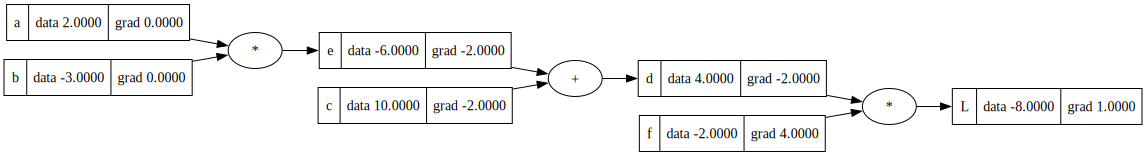

In [91]:
draw_dot(L)

In [92]:
# derivative of L wrt c
def rough4(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')

    # bumped c by h
    c = Value(10.0 + h, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough4()

-1.9999999999953388


dL/da =? and dL/db =?

e = a * b

we already know what happens to derivatives when there's a * operator, the gradients are values of nodes reversed. So,

de/da = b = -3.0

de/db = a = 2.0

KNOW
dL/de = -2.0

WANT
dL/da

by chain rule,

dL/da = dL/de * de/da

dL/da = -2.0 * -3.0

similarly,

dL/db = dL/de * de/db

dL/db = -2.0 * 2.0



In [95]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

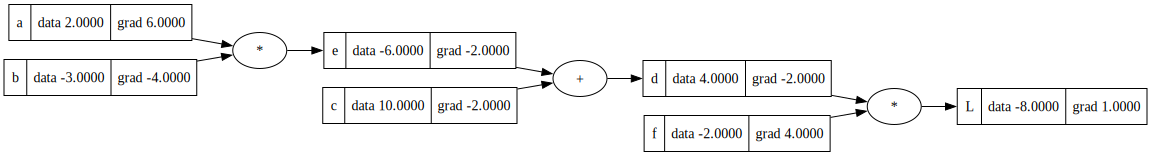

In [96]:
draw_dot(L)

In [97]:
# derivative of L wrt a
def rough5(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    # bumped a by h
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough5()

6.000000000021544


In [98]:
# let's see how changing the values of some nodes impacts L
# we'll change only the leaf nodes

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# re-running the "forward pass"

e = a * b
d = e + c
L = d*f

L

Value(data=-7.286496)

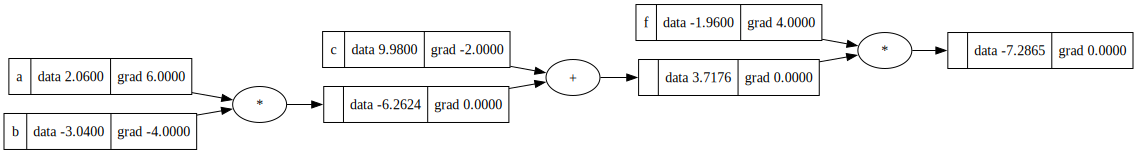

In [99]:
draw_dot(L)